In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns



ModuleNotFoundError: No module named 'pytorch_lightning'

In [3]:
#import data
df = pd.read_csv('data/Recidivism_Data_cleaned.csv')
df_original = df.copy()

In [4]:
# We only want to predict recidivism within 3 years
#We are also looking at just Males
df.drop(['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Gender'], axis=1, inplace=True)

# Remove variables thaat are determined only after prison release
df.drop(['Supervision_Risk_Score_First', 'Supervision_Level_First',
         'Violations_ElectronicMonitoring', 'Violations_FailToReport','Violations_FailToReport', 'Violations_MoveWithoutPermission',
         'Delinquency_Reports', 'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes', 
         'DrugTests_THC_Positive', 'DrugTests_Cocaine_Positive','DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 
         'Percent_Days_Employed', 'Jobs_Per_Year', 'Employment_Exempt'], axis=1, inplace=True)

### Data Preprocessing

In [5]:
#Chance all Booleans to Integers
for column in df.columns:
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Dummy Variable for Race 
df['Race'] = df['Race'].map({'BLACK': 1, 'WHITE': 0})

# Change age to integer as opposed to float
df['Age_at_Release'] = df['Age_at_Release'].astype(int)


In [6]:
# Interger Encoded to for embeddings in NN
df['Prison_Offense'] = df['Prison_Offense'].map({category: idx for idx, category in enumerate(df['Prison_Offense'].unique())})
df['Education_Level'] = df['Education_Level'].map({'Less than HS diploma': 0, 'High School Diploma': 1, 'At least some college': 2})

In [7]:
# Make Recidivism_Within_3years the last column
cols = [col for col in df.columns if col != 'Recidivism_Within_3years']
cols.append('Recidivism_Within_3years')
df = df[cols]

In [8]:
# Variables to normalize
columns_to_normalize = ['Age_at_Release', 'Prison_Years']  # add other columns here

# Apply Standardization
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


In [9]:
#Split Train and Test Data
train_df = df[df['Training_Sample'] == 1]
test_df = df[df['Training_Sample'] == 0]
train_df = train_df.drop(columns=['Training_Sample'])
test_df = test_df.drop(columns=['Training_Sample'])

In [10]:
#X = train_df.drop('Recidivism_Within_3years', axis=1)
#y = train_df['Recidivism_Within_3years']

#X_test = test_df.drop('Recidivism_Within_3years', axis=1)
#y_test = test_df['Recidivism_Within_3years']

# Normalize continuous features (if necessary)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


In [11]:
df.columns

Index(['Race', 'Age_at_Release', 'Residence_PUMA', 'Gang_Affiliated',
       'Education_Level', 'Dependents', 'Prison_Offense', 'Prison_Years',
       'Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd',
       'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',
       'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Other', 'Violations_Instruction', 'Training_Sample',
       'Required

### MLP

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [11]:
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): source data
        """
        # Assuming the last column is the label
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Convert features and labels to tensors
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label


In [12]:
#Convert pd dataframe to torch dataset
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(train_df)

# use 15% of training data for validation
train_set_size = int(len(train_dataset) * 0.85)
valid_set_size = len(train_dataset) - train_set_size
train_set, valid_set = torch.utils.data.random_split(train_dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
total_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [13]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Create fully connected layers (nn.Linear)
        ### START CODE ###
        self.fc1 = nn.Linear(31, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        ### END CODE ###

    def forward(self, x):
        ### START CODE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ### END CODE ###
        return x


In [14]:
model = MLP()
# Create the optimizer
### START CODE ###
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
### END CODE ###

In [15]:
# Create the loss function instance
criterion = torch.nn.BCEWithLogitsLoss()

def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Use the optimizer to perform backpropagation
        ### START CODE ###
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE ###

        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    return avg_loss

@torch.no_grad()
def eval(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_num = 0
    for data, target in tqdm(loader):
        out = model(data)
        # Calculate loss based on model output and target
        ### START CODE ###
        target = target.unsqueeze(1) 
        loss = criterion(out, target.float())
        ### END CODE ###

        # Get model's prediction
        ### START CODE ###
        pred = torch.sigmoid(out) >= 0.5
        ### END CODE ###

        # Count number of correct predictions
        ### START CODE ###
        correct = (pred.float() == target.float()).sum().item()
        ### END CODE ###

        total_correct += correct
        batch_size = len(target)
        total_loss += loss.item() * batch_size
        total_num += batch_size
    avg_loss = total_loss / total_num
    acc = total_correct / total_num
    return avg_loss, acc


In [16]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer)
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

100%|██████████| 10/10 [00:00<00:00, 499.97it/s]


Epoch: 1 Train Loss: 0.659073130818685 Val Loss: 0.6241823995696353 Val Acc: 0.6627318718381113


100%|██████████| 10/10 [00:00<00:00, 512.24it/s]


Epoch: 2 Train Loss: 0.6123003731464752 Val Loss: 0.5884639493128502 Val Acc: 0.6960370994940978


100%|██████████| 10/10 [00:00<00:00, 475.67it/s]


Epoch: 3 Train Loss: 0.5993320509271347 Val Loss: 0.5840191059128631 Val Acc: 0.6960370994940978


100%|██████████| 10/10 [00:00<00:00, 487.52it/s]


Epoch: 4 Train Loss: 0.5971327765825843 Val Loss: 0.5794229290336622 Val Acc: 0.7061551433389545


100%|██████████| 10/10 [00:00<00:00, 522.75it/s]


Epoch: 5 Train Loss: 0.5921799807119551 Val Loss: 0.5767467305390871 Val Acc: 0.7019392917369308


100%|██████████| 10/10 [00:00<00:00, 488.71it/s]


Epoch: 6 Train Loss: 0.5918779240246019 Val Loss: 0.5758656241238419 Val Acc: 0.7082630691399663


100%|██████████| 10/10 [00:00<00:00, 514.53it/s]


Epoch: 7 Train Loss: 0.5901072970440066 Val Loss: 0.5806983989768647 Val Acc: 0.6989881956155143


100%|██████████| 10/10 [00:00<00:00, 503.91it/s]


Epoch: 8 Train Loss: 0.5906626619223958 Val Loss: 0.576112212961882 Val Acc: 0.7015177065767285


100%|██████████| 10/10 [00:00<00:00, 540.00it/s]


Epoch: 9 Train Loss: 0.5878694719462463 Val Loss: 0.577721935902639 Val Acc: 0.7082630691399663


100%|██████████| 10/10 [00:00<00:00, 526.56it/s]


Epoch: 10 Train Loss: 0.5874849901338429 Val Loss: 0.5742628862845757 Val Acc: 0.7086846543001686


100%|██████████| 10/10 [00:00<00:00, 512.14it/s]


Epoch: 11 Train Loss: 0.5872442696773809 Val Loss: 0.5761577742296768 Val Acc: 0.7015177065767285


100%|██████████| 10/10 [00:00<00:00, 489.27it/s]


Epoch: 12 Train Loss: 0.586409099959433 Val Loss: 0.5747067551387703 Val Acc: 0.7065767284991569


100%|██████████| 10/10 [00:00<00:00, 512.28it/s]


Epoch: 13 Train Loss: 0.5842518020983706 Val Loss: 0.5752803913457397 Val Acc: 0.7053119730185498


100%|██████████| 10/10 [00:00<00:00, 542.73it/s]


Epoch: 14 Train Loss: 0.5834749695960055 Val Loss: 0.5782350510811122 Val Acc: 0.7015177065767285


100%|██████████| 10/10 [00:00<00:00, 526.55it/s]

Epoch: 15 Train Loss: 0.5850116338427556 Val Loss: 0.5734893378077631 Val Acc: 0.7023608768971332


In [17]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    acc = total_correct / total_num
    return acc, all_preds, all_targets

test_acc, all_preds, all_targets = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Test Accuracy: 69.62%


In [23]:
@torch.no_grad()
def test_accuracy(model, loader):
    model.eval()
    total_correct = 0
    total_num = 0
    all_preds = []
    all_targets = []
    all_probs = []  # To store probability estimates

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out) >= 0.5
        correct = (pred.float() == target.unsqueeze(1).float()).sum().item()

        total_correct += correct
        total_num += len(target)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_probs.extend(torch.sigmoid(out).cpu().numpy())  # Store probability estimates

    acc = total_correct / total_num
    return acc, all_preds, all_targets, all_probs  # Return probability estimates


In [25]:
from sklearn.metrics import brier_score_loss

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

# Calculate the Brier Score using probability estimates
test_acc, _, _, all_probs = test_accuracy(model, test_loader)
brier_score = brier_score_loss(all_targets, all_probs)
print(f"Brier Score on Test Set: {brier_score:.4f}")

ROC AUC Score on Test Set: 0.7634
Brier Score on Test Set: 0.1908


In [18]:
epochs = 15
for e in range(1, epochs + 1):
    train_loss = train(model, total_train_loader, optimizer)  # Use total_train_loader
    val_loss, val_acc = eval(model, val_loader)
    print(f"Epoch: {e} Train Loss: {train_loss} Val Loss: {val_loss} Val Acc: {val_acc}")

# After training, evaluate on the test set
test_acc, all_preds, all_targets = test_accuracy(model, test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


100%|██████████| 10/10 [00:00<00:00, 473.48it/s]


Epoch: 1 Train Loss: 0.5805672775461811 Val Loss: 0.5705121323390916 Val Acc: 0.7057335581787522


100%|██████████| 10/10 [00:00<00:00, 464.28it/s]


Epoch: 2 Train Loss: 0.5791749614223448 Val Loss: 0.5694049852091385 Val Acc: 0.7112141652613828


100%|██████████| 10/10 [00:00<00:00, 454.73it/s]


Epoch: 3 Train Loss: 0.5794989440693107 Val Loss: 0.5698455173088769 Val Acc: 0.7099494097807757


100%|██████████| 10/10 [00:00<00:00, 509.85it/s]


Epoch: 4 Train Loss: 0.5771143021412256 Val Loss: 0.5671381528220731 Val Acc: 0.7061551433389545


100%|██████████| 10/10 [00:00<00:00, 487.15it/s]


Epoch: 5 Train Loss: 0.5761268748804889 Val Loss: 0.5674311925749754 Val Acc: 0.7082630691399663


100%|██████████| 10/10 [00:00<00:00, 500.24it/s]


Epoch: 6 Train Loss: 0.5741162951987364 Val Loss: 0.5637402300287861 Val Acc: 0.7078414839797639


100%|██████████| 10/10 [00:00<00:00, 516.20it/s]


Epoch: 7 Train Loss: 0.5745614908555979 Val Loss: 0.5641697039089557 Val Acc: 0.7171163575042159


100%|██████████| 10/10 [00:00<00:00, 476.00it/s]


Epoch: 8 Train Loss: 0.5726649400993524 Val Loss: 0.5624214971648501 Val Acc: 0.7141652613827993


100%|██████████| 10/10 [00:00<00:00, 476.38it/s]


Epoch: 9 Train Loss: 0.5718146875923842 Val Loss: 0.5605257744531809 Val Acc: 0.7141652613827993


100%|██████████| 10/10 [00:00<00:00, 500.01it/s]


Epoch: 10 Train Loss: 0.5726002528043017 Val Loss: 0.5598308110317533 Val Acc: 0.7179595278246206


100%|██████████| 10/10 [00:00<00:00, 499.96it/s]


Epoch: 11 Train Loss: 0.5694769117661939 Val Loss: 0.5584095051075516 Val Acc: 0.718381112984823


100%|██████████| 10/10 [00:00<00:00, 487.12it/s]


Epoch: 12 Train Loss: 0.5696467557047525 Val Loss: 0.5597304416346107 Val Acc: 0.7137436762225969


100%|██████████| 10/10 [00:00<00:00, 514.06it/s]


Epoch: 13 Train Loss: 0.5700987154275912 Val Loss: 0.5611130204208786 Val Acc: 0.7099494097807757


100%|██████████| 10/10 [00:00<00:00, 108.09it/s]


Epoch: 14 Train Loss: 0.5681164442275237 Val Loss: 0.5563740395574908 Val Acc: 0.7188026981450253


100%|██████████| 10/10 [00:00<00:00, 486.04it/s]


Epoch: 15 Train Loss: 0.5659808231843173 Val Loss: 0.5538377861349418 Val Acc: 0.7200674536256324
Test Accuracy: 70.81%


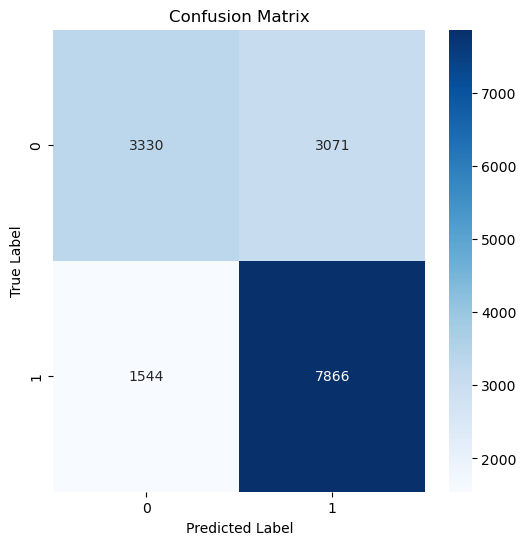

In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [22]:
@torch.no_grad()
def test_roc_auc(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    for data, target in loader:
        out = model(data)
        pred = torch.sigmoid(out)
        
        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

    roc_auc = roc_auc_score(all_targets, all_preds)
    return roc_auc

roc_auc = test_roc_auc(model, test_loader)
print(f"ROC AUC Score on Test Set: {roc_auc:.4f}")

ROC AUC Score on Test Set: 0.7634
